## Kaggle Catch Me If You Can

https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2

In [2]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

# импорт библиотек

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

In [3]:
# прочитаем данные 

train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [4]:
# подгрузим словарь сайтов

with open('data/site_dic.pkl', 'rb') as f:
        site2id = pickle.load(f)

# для удобства сделаем id ключами
id2site = {value:key for (key, value) in site2id.items()}

# добавим заглушку для отсутствующих данных
id2site[0] = 'unknown'

In [5]:
# разреженная матрица для данных о посещенных сайтах

sites = ['site%s' % i for i in range(1,11)]

def sites_sessions(df):
    sessions = df[sites].fillna(0).astype('int').apply(lambda row:
                                                    ' '.join([id2site[i] for i in row]),
                                                       axis=1).tolist()
    return sessions

train_sessions = sites_sessions(train_df)
test_sessions = sites_sessions(test_df)


# vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=50000)
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=50000, tokenizer=lambda s: s.split())

X_train = vectorizer.fit_transform(train_sessions)
X_test = vectorizer.transform(test_sessions)

In [6]:
# добавим признак продолжительности сессии

def session_duration(row):
    clean_row = [item for item in row if item is not pd.NaT]
    if len(clean_row) == 0:
        return 0
    else:
        delta = clean_row[-1] - clean_row[0]
        return delta.seconds

times = ['time%s' % i for i in range(1, 11)]
    
train_df['session_duration'] = train_df[times].apply(session_duration, axis=1)
test_df['session_duration'] = test_df[times].apply(session_duration, axis=1)

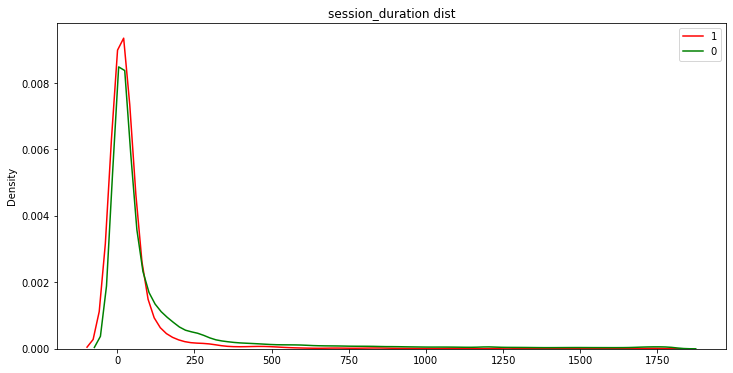

In [7]:
plt.figure(figsize=(12, 6))

def dist_plot(data, feature, target):
    
    sns.kdeplot(data[data[target] == 1][feature], label = '1', color = 'red')
    sns.kdeplot(data[data[target] == 0][feature], label = '0', color = 'green')
    
    plt.ylabel('Density')
    plt.title(feature + ' dist')
    plt.show()
    
    
dist_plot(train_df, 'session_duration', 'target')

In [8]:
# добавлю признак часа начала сессии

train_df['start_hour'] = train_df['time1'].dt.hour
test_df['start_hour'] = test_df['time1'].dt.hour

train_df['weekday'] = train_df['time1'].dt.weekday
test_df['weekday'] = test_df['time1'].dt.weekday

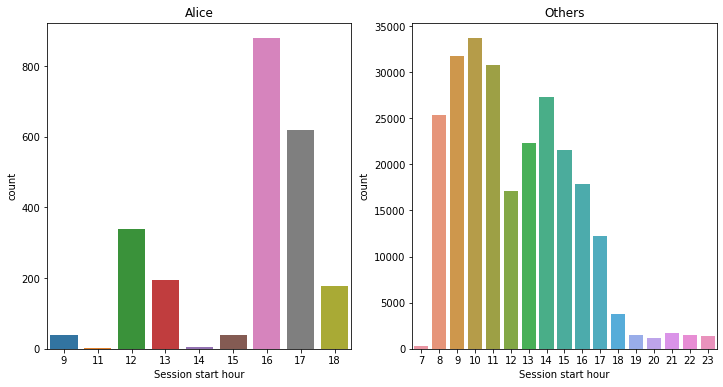

In [9]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(train_df[train_df['target'] == 1]['start_hour'])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(train_df[train_df['target'] == 0]['start_hour'])
plt.title('Others')
plt.xlabel('Session start hour');

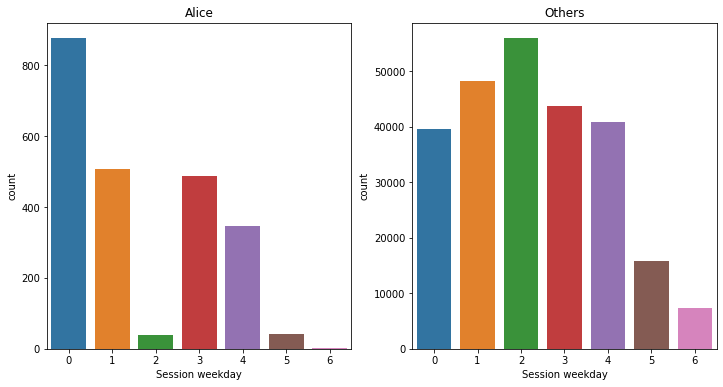

In [10]:
plt.subplots(1, 2, figsize = (12, 6)) 

plt.subplot(1, 2, 1)
sns.countplot(train_df[train_df['target'] == 1]['weekday'])
plt.title("Alice")
plt.xlabel('Session weekday')
          
plt.subplot(1, 2, 2)
sns.countplot(train_df[train_df['target'] == 0]['weekday'])
plt.title('Others')
plt.xlabel('Session weekday');

In [11]:
# добавим временные фичи

def time_features(df):
    df['night'] = df['start_hour'].apply(lambda x: 1 if x>=0 and x<7 else 0)
    df['morning'] = df['start_hour'].apply(lambda x: 1 if x>=7 and x<12 else 0)
    df['day'] = df['start_hour'].apply(lambda x: 1 if x>=12 and x<19 else 0)
    df['evening'] = df['start_hour'].apply(lambda x: 1 if x>=19 else 0)
    df['year_month'] = df['time1'].apply(lambda ts: 100*ts.year+ts.month)
    df['weekend'] = df['weekday'].apply(lambda x: 1 if x>=5 else 0)
    df['month'] = df['time1'].dt.month

    return df

train_df = time_features(train_df)
test_df = time_features(test_df)

In [12]:
# стандартизация данных

features_to_scale = ['session_duration', 'year_month']
scaler = StandardScaler()
scaler.fit(train_df[features_to_scale].values) # .reshape(-1, 1)

train_df[features_to_scale] = scaler.transform(train_df[features_to_scale].values)
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale].values)

In [13]:
X_train = csr_matrix(hstack([X_train,
                  train_df[['session_duration', 'year_month', 'night', 'morning', 'day', 'night', 'evening', 'weekday']].values]))

X_test = csr_matrix(hstack([X_test,
                  test_df[['session_duration', 'year_month', 'night', 'morning', 'day', 'night', 'evening', 'weekday']].values]))

y_train = train_df['target']

In [14]:
%%time

y_train = train_df['target']
time_split = TimeSeriesSplit(n_splits=10)
logit = LogisticRegression(C=1, random_state=17, solver='sag')

cv_scores1 = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

cv_scores1.mean()

CPU times: user 176 ms, sys: 860 ms, total: 1.04 s
Wall time: 23.8 s


0.9246273188233298

In [15]:
%%time
lgbm = LGBMClassifier(n_jobs=-1, random_state=17)

cv_scores2 = cross_val_score(lgbm, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

cv_scores2.mean()

CPU times: user 200 ms, sys: 832 ms, total: 1.03 s
Wall time: 1min 22s


0.9187403632290867

In [16]:
cv_scores2 > cv_scores1

array([False,  True, False,  True, False, False, False,  True, False,
        True])

In [17]:
# подберем параметры для логистической регрессии

logit_params = {'C': np.logspace(-2, 2, 20)}

logit_grid = GridSearchCV(estimator=logit, param_grid=logit_params,
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=0)

logit_grid.fit(X_train, y_train)
final_logit = logit_grid.best_estimator_
print('Logit final score is {}'.format(logit_grid.best_score_))

Logit final score is 0.9271018850828497


In [18]:
final_logit.fit(X_train, y_train)
predictions = final_logit.predict_proba(X_test)[:,1]

In [19]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
write_to_submission_file(predictions, 'subm2.csv')